<a href="https://colab.research.google.com/github/mohan-mj/Predict_Price_from_Text-NLP-Ensemble-Tensorflow-Case_study/blob/master/Predict_Price_from_Text-NLP-Ensemble-Tensorflow-Case_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf

In [0]:
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras

In [0]:
layers = keras.layers

In [4]:
tf.__version__

'1.14.0'

In [0]:
!wget -q https://storage.googleapis.com/sara-cloud-ml/wine_data.csv

In [6]:
data = pd.read_csv("wine_data.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150929 entries, 0 to 150928
Data columns (total 11 columns):
Unnamed: 0     150929 non-null int64
country        150924 non-null object
description    150929 non-null object
designation    105195 non-null object
points         150929 non-null int64
price          137234 non-null float64
province       150924 non-null object
region_1       125870 non-null object
region_2       60953 non-null object
variety        150929 non-null object
winery         150929 non-null object
dtypes: float64(1), int64(2), object(8)
memory usage: 12.7+ MB


In [7]:
data.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


In [8]:
np.unique(data['variety']).shape

(632,)

In [9]:
data.dropna(subset=['country', 'price'], inplace=True)
data.shape

(137229, 11)

In [10]:
value_counts = data['variety'].value_counts()
to_remove = value_counts[value_counts <= 500].index
data.replace(to_remove, np.nan, inplace=True)
data.dropna(subset=['variety'], inplace=True)
data.shape

(119558, 11)

## Split data into a training and testing set and extract the features and labels

In [35]:
train_size = int(len(data) * .8)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(data) - train_size))

#Train features
description_train = data['description'][:train_size]
variety_train = data['variety'][:train_size]

#Train label
labels_train = data['price'][:train_size]

#Test features
description_test = data['description'][train_size:]
variety_test = data['variety'][train_size:]

#Test label
labels_test = data['price'][train_size:]

Train size: 95646
Test size: 23912


## Feature 1: Wine description - BoW

In [0]:
vocab_size = 12000
tokenize = keras.preprocessing.text.Tokenizer(num_words=vocab_size, char_level=False)

In [0]:
tokenize.fit_on_texts(description_train)

In [0]:
description_bow_train = tokenize.texts_to_matrix(description_train)
description_bow_test = tokenize.texts_to_matrix(description_test)


In [0]:
# #memory optimization
# del description_bow_train
# del description_bow_test

## Wide feature 2: one-hot vector of variety categories

In [0]:
encoder = LabelEncoder()
encoder.fit(variety_train)
variety_train = encoder.transform(variety_train)
variety_test = encoder.transform(variety_test)
num_classes = np.max(variety_train) + 1

In [0]:
# Convert labels to one hot
variety_train = keras.utils.to_categorical(variety_train, num_classes)
variety_test = keras.utils.to_categorical(variety_test, num_classes)

## Define our wide model with the functional API

In [0]:
# Define our wide model with the functional API
bow_inputs = layers.Input(shape=(vocab_size,))
variety_inputs = layers.Input(shape=(num_classes,))
merged_layer = layers.concatenate([bow_inputs, variety_inputs])
merged_layer = layers.Dense(256, activation='relu')(merged_layer)
predictions = layers.Dense(1)(merged_layer)
wide_model = keras.Model(inputs=[bow_inputs, variety_inputs], outputs=predictions)

In [43]:

wide_model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
print(wide_model.summary())

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 12000)]      0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 12040)        0           input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 256)          3082496     concatenate_2[0][0]        

In [0]:
train_embed = tokenize.texts_to_sequences(description_train)
test_embed = tokenize.texts_to_sequences(description_test)

In [0]:
max_seq_length = 170
train_embed = keras.preprocessing.sequence.pad_sequences(
    train_embed, maxlen=max_seq_length, padding="post")
test_embed = keras.preprocessing.sequence.pad_sequences(
    test_embed, maxlen=max_seq_length, padding="post")

135


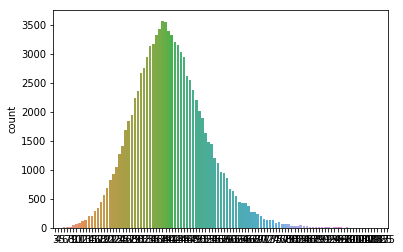

In [22]:
from collections import Counter
import seaborn as sns
tmp = [len(i.split()) for i in description_train]
print (max(tmp))
sns.countplot(tmp)
del tmp

In [23]:
deep_inputs = layers.Input(shape=(max_seq_length,))
embedding = layers.Embedding(vocab_size, 8,   input_length=max_seq_length)(deep_inputs)
embedding = layers.Flatten()(embedding)

W0818 15:32:31.491731 140090847864704 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [24]:
embed_out = layers.Dense(1)(embedding)
deep_model = keras.Model(inputs=deep_inputs, outputs=embed_out)
print(deep_model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 170)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 170, 8)            96000     
_________________________________________________________________
flatten (Flatten)            (None, 1360)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1361      
Total params: 97,361
Trainable params: 97,361
Non-trainable params: 0
_________________________________________________________________
None


In [0]:

deep_model.compile(loss='mse',
                       optimizer='adam',
                       metrics=['accuracy'])

In [26]:
# Combine wide and deep into one model
merged_out = layers.concatenate([wide_model.output, deep_model.output])
merged_out = layers.Dense(1)(merged_out)
combined_model = keras.Model(wide_model.input + [deep_model.input], merged_out)
print(combined_model.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 12000)]      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 170)]        0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 12040)        0           input_1[0][0]                    
                                                                 input_2[0][0]              

In [0]:
combined_model.compile(loss='mse',
                       optimizer='adam',
                       metrics=['accuracy'])

In [28]:
# Run training
combined_model.fit([description_bow_train, variety_train] + [train_embed], 
                   labels_train, epochs=10, batch_size=128)

Epoch 1/10
95646/95646 [==============================] - 10s 101us/sample - loss: 1242.5921 - acc: 0.0000e+00
Epoch 2/10
95646/95646 [==============================] - 9s 92us/sample - loss: 976.7146 - acc: 0.0000e+00
Epoch 3/10
95646/95646 [==============================] - 9s 93us/sample - loss: 827.6356 - acc: 0.0000e+00
Epoch 4/10
95646/95646 [==============================] - 10s 100us/sample - loss: 689.7040 - acc: 0.0000e+00
Epoch 5/10
95646/95646 [==============================] - 9s 95us/sample - loss: 562.2914 - acc: 0.0000e+00
Epoch 6/10
95646/95646 [==============================] - 9s 97us/sample - loss: 451.4071 - acc: 0.0000e+00
Epoch 7/10
95646/95646 [==============================] - 9s 96us/sample - loss: 355.5279 - acc: 0.0000e+00
Epoch 8/10
95646/95646 [==============================] - 9s 96us/sample - loss: 276.5166 - acc: 0.0000e+00
Epoch 9/10
95646/95646 [==============================] - 9s 97us/sample - loss: 214.4856 - acc: 0.0000e+00
Epoch 10/10
95646/95646

In [29]:
description_bow_train.shape

(95646, 12000)

In [30]:
variety_train.shape

(95646, 40)

In [31]:
train_embed.shape

(95646, 170)

In [46]:

combined_model.evaluate([description_bow_test, variety_test] + [test_embed], labels_test, batch_size=128)

23912/23912 [==============================] - 2s 73us/sample - loss: 365.6704 - acc: 0.0000e+00


[365.6704425396988, 0.0]

In [0]:
# Generate predictions
predictions = combined_model.predict([description_bow_test, variety_test] + [test_embed])

In [48]:
# Compare predictions with actual values for the first few items in our test dataset
num_predictions = 40
diff = 0

for i in range(num_predictions):
    val = predictions[i]
    print(description_test.iloc[i])
    print('Predicted: ', val[0], 'Actual: ', labels_test.iloc[i], '\n')
    diff += abs(val[0] - labels_test.iloc[i])

As happens with Chenin wines, this has closed up, showing only marzipan flavors without the fruit. It's a stage, and the wine needs another 2–3 years before realizing its mature potential. Screwcap.
Predicted:  14.582488 Actual:  16.0 

H3 is Columbia Crest's line of wines from the Horse Heaven Hills AVA—the winery's home turf—and the wines seem to have a bit more cut and flair than the slightly less expensive Columbia Valley bottlings. Here you will find a more complex blend of fruits—starfruit, apple, melon and a hint of banana—and less focus on butter and toast. In other words, more of a food and sipping wine.
Predicted:  13.596732 Actual:  15.0 

Very ripe and fruity in the modern style, almost too strong in blackberry jam, black currant and oak flavors that are not particularly subtle or delicate, although the wine is thoroughly dry. The tannins are significant, but negotiable. The suggestion is ageability. Give it 2–4 years and try again.
Predicted:  45.12752 Actual:  45.0 

Note

In [49]:
# Compare the average difference between actual price and the model's predicted price
print('Average prediction difference: ', diff / num_predictions)

Average prediction difference:  3.5842127799987793
